# Introduction Gradient Descent

In diesem Notebook werden wir das Konzept des Gradientenabstiegs anhand einer linearen Regression erarbeiten.
Wir starten mit der Generierung von synthetischen Daten, definieren unser Modell und die Kostenfunktion (Loss Function)
und implementieren anschließend den Optimierungsalgorithmus Schritt für Schritt.

**What to do next**
- Mit Abschluss dieses Notebooks werden die Grundlagen gelegt um im nächsten Chapter die Grenzen des GD zu verstehen bei nicht linearen Feauturedimensionen und Räumen.
- Start with the Backpropagation Chapter


In [ ]:
import numpy as np, importlib
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [ ]:
rng = np.random.default_rng(53)

## 1. Datengenerierung

Zuerst generieren wir synthetische Daten, die einer linearen Beziehung folgen: $y = wx + b + \epsilon$.
Dabei fügen wir ein Rauschen (Noise) $\epsilon$ hinzu, um reale Bedingungen zu simulieren.

In [ ]:
true_m = 2
true_b = 2
num_gen_values = 1000
x = np.linspace(-5,5, num_gen_values) # no linkage term in MSE without noise
true_y = true_m * x + true_b
sigma = 0.9
white_noise = rng.normal(0.0, sigma, num_gen_values)
observed_y = true_y + white_noise


## 2. Datenvisualisierung
Visualisierungen der Daten helfen uns einen Verständnis zu unseren Daten zu bilden, Probleme Frühzeitig zu erkennen und vieles mehr.

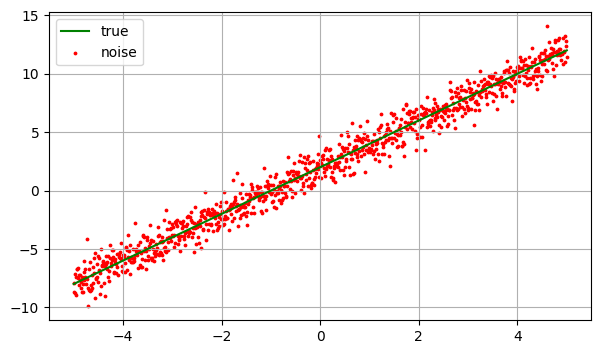

In [ ]:
def viz_data(viz_func,x_func, x_split, y_split,predlabel,func_label="true"):
  fig, ax = plt.subplots(figsize=(7,4))
  ax.plot(x, viz_func, c="green", label=func_label)
  ax.scatter(x_split, y_split, s=3, c="red", label=predlabel)
  ax.legend()
  ax.grid()
  return fig, ax

fig0, ax0 = viz_data(true_y,x,x,observed_y,"noise")


## 3. Generierung der Training und Validierungsdaten
Aus unseren synthetisch erzeugten Daten erstellen wir ein Trainings und Validierungsplit, um das Modell auf einem Teil der Daten zu trainieren und seine Fähigkeit zur Generalisierung auf bisher ungesehene Daten zu überprüfen.

In [ ]:
def split(x,y,val_size=0.2, n=num_gen_values):
  idx = rng.permutation(n)
  n_val = int((n* val_size))
  n_train = n - n_val
  train_idx = idx[:n_train]
  val_idx = idx[n_train:]
  x_train, x_val = x[train_idx], x[val_idx]
  y_train, y_val = y[train_idx], y[val_idx]
  return x_train, x_val, y_train, y_val, train_idx, val_idx


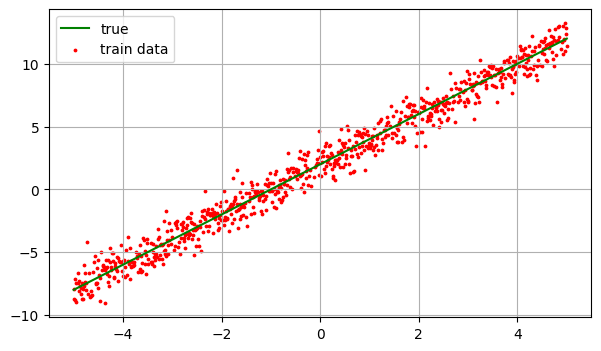

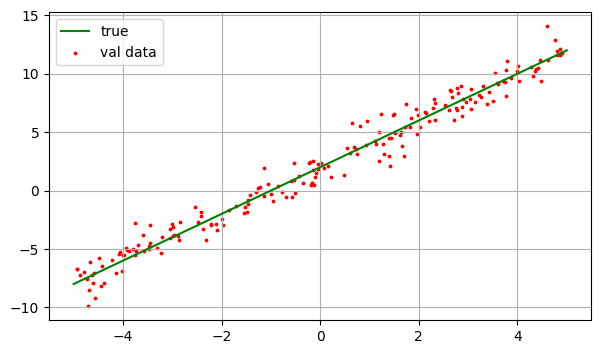

In [ ]:
x_train, x_val, y_train, y_val, t_idx, v_idx = split(x,observed_y)

fig1, ax1 = viz_data(true_y,x,x_train,y_train,"train data")
fig2, ax2 = viz_data(true_y,x,x_val,y_val,"val data")


## 4. Zufällige Initialisierung der Modellparameter
Wir initilalsieren die Parameter **w** und **b** zufällig.


In [ ]:
w = rng.random()
b = rng.random()

def predict(x,w,b):
  y_hat = w * x + b
  return y_hat

y_hat = predict(x_train,w,b)

print(f"zufällige Initialisierung mit Steigung von: {w} und Achsenabschnitt {b}")

zufällige Initialisierung mit Steigung von: 0.507637862250508 und Achsenabschnitt 0.8148854343292782


Plotten wir nun die Prediction y_hat mit unseren zufälligen Parametern.




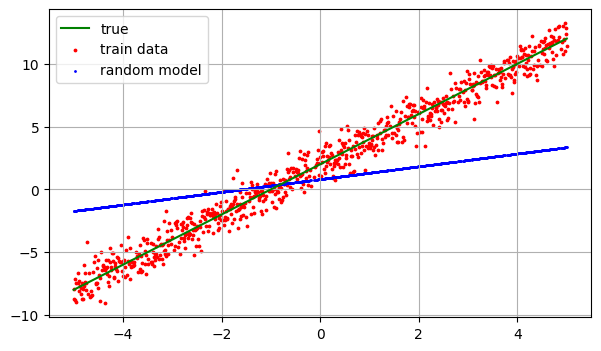

In [ ]:
ax1.scatter(x_train,y_hat, color="blue", label="random model", s=1)
ax1.legend()
fig1

## 5.Lossfunction

Wir können direkt erkennen, dass unsere zufällig generierte Funktion die Daten nicht gut abbildet. Um das zu quantifizieren, brauchen wir eine Verlustfunktion.

Für das Regressionsproblem, welches wir lösen wollen, halten wir es simpel mit dem Mean Squared Error. Wie man in der Summenschreibweise erkennt, gibt es bei unserem linearen Modell einen Kopplungsterm $2 \cdot b \cdot w \cdot \sum(x)$. Durch das Zentrieren von $x$ wird die Summe 0 und somit fällt der Term später weg. Bei unseren Daten mit Rauschen wird dieser kleiner und auch somit der Einfluss von $w$ auf $b$ in Bezug auf das MSE und vice versa.




$$
\begin{aligned}
\displaystyle
MSE &= \frac{1}{n} \sum\limits_{i=1}^{n} error_i^2 \\[8pt]
    &= \frac{1}{n} \sum\limits_{i=1}^{n} (\hat{y}_i - y_i)^2 \\[8pt]
    &= \frac{1}{n} \sum\limits_{i=1}^{n} (b + w x_i - y_i)^2 \\[8pt]
    &= \frac{1}{n} \Bigg(
        \sum\limits_{i=1}^{n} y_i^2
        - 2b \sum\limits_{i=1}^{n} y_i
        - 2w \sum\limits_{i=1}^{n} x_i y_i
        + b^2 n
        + {\color{red}{2bw \sum\limits_{i=1}^{n} x_i}}
        + w^2 \sum\limits_{i=1}^{n} x_i^2
      \Bigg)
\end{aligned}
$$

Als nächstes setzen wir den Error über den Trainingsdatensatz in unsere Funktion ein, hier über error = (yhat-y).

In [ ]:
def mse(y, y_hat):
  return (1/len(y)) * np.sum((y_hat-y)**2)

def dmse_dyhat(y,y_hat):
  return (2/y.size) * (y_hat-y)

loss = mse(y_train,y_hat)
print(loss)


20.28441569406824


Auch wenn manche direkt durch scharfes sehen erkennen, dass große Außreißer in unseren Daten stärker in den MSE einfließen, macht es Sinn sich die Funktion plotten zu lassen, sodass man auf Anhieb auch erkennt wieso. Der Übertrag zum Gradientenabstieg (dazu gleich mehr) findet statt wenn man auch die Ableitung der Funktion genauer anschaut damit man auch den Einfluss der Lossfunction auf den Graidenten erkennt.

Häufig wird die Fehlannahme getroffen man könnte ein Datensatz einfach explorieren und Außreißer entfernen, jedoch kann man damit sehr schnell fehlannahen treffen. Im Beispiel der Biologie wird dass schnell deutlich, sehr häufig haben gleiche Blutproben die man zur Untersuchung in unterschiedliche Labore schickt, unterschiedliche Blutwerte. Dass kann durch unterschiedliche Messmethoden, schlechter Kühlung beim Transport oder intrinsichen Reaktionen entstehen. Unser Modell soll lernen mit rauschen umzugehen. Natürlich bedeutet es nicht das man offensichtliche Messfehler bereinigen sollte. Aber es ist ein heikles Thema da meist Domänenwissen erforderlich ist.

Findige Leser werden sofort über eine Methodik nachdenken wie man z.B durch skalierende Transformationen und Normalisierungsverfahren den MSE besser unter Kontrolle hält. Das werden wir in einem anderen Kapitel genauer behandeln.

In unserem zweiten Plott würden wir auch sofort den einfluss vom MSE auf den Gradientenabstieg erkennen. Große Residuen führen zu hohen Steigungen im Fehlerterm, was wiederum zu großen Gradienten führt. Ein Teufelskreislauf.

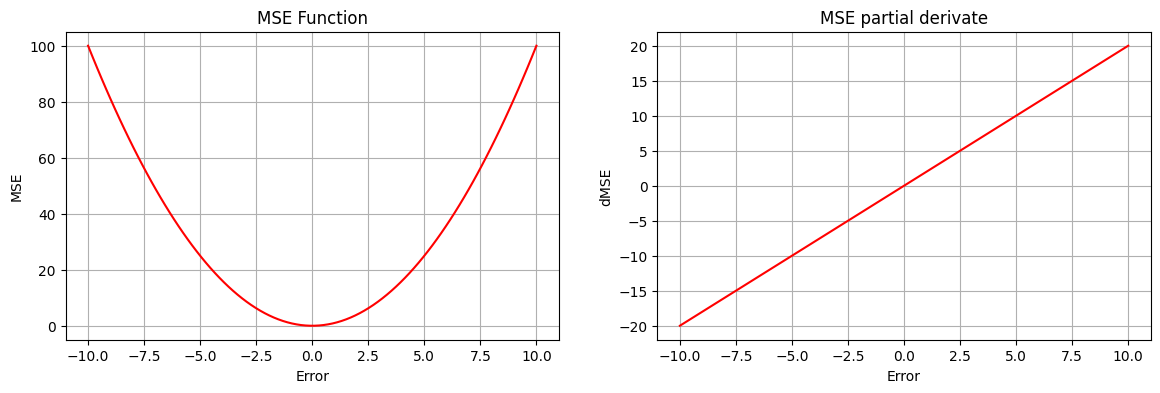

In [ ]:
viz_true_y = np.zeros(1)
viz_range_y = np.linspace(-10,10, 100)
viz_mse = [mse(viz_true_y,i) for i in viz_range_y]
viz_dmse = [dmse_dyhat(viz_true_y,i) for i in viz_range_y]

fig3, (ax3,ax4) = plt.subplots(1,2,figsize=(14,4))

ax3.plot(viz_range_y, viz_mse, c="r")
ax3.set_ylabel("MSE")
ax3.set_xlabel("Error")
ax3.set_title("MSE Function")
ax3.grid()

ax4.plot(viz_range_y, viz_dmse, c="r")
ax4.set_ylabel("dMSE")
ax4.set_xlabel("Error")
ax4.set_title("MSE partial derivate")
ax4.grid()


Für Simulationszwecke wird nun eine kleine Klasse angelegt, um später bei der Visualisierung Coderedundazen zu vermeiden. Diese Zelle kann gerne übersprungen werden.

In [ ]:
class Calculator():
  def __init__(self, x: np.ndarray, y: np.ndarray, start_axis=0, stop_axis=4):
    try:
      assert x.size == y.size, "Shape missmatch, can cause Problems later"
    except AssertionError as error:
      print(error)
    self.x = x
    self.y = y
    #Terms
    self.Syy = np.sum(y**2)
    self.Sxy = np.sum(y * x)
    self.Sxx = np.sum(x**2)
    self.Sx = np.sum(x)
    self.Sy = np.sum(y)
    self.n = len(y)

    #axis
    self.w_axis : np.ndarray | None = None
    self.b_axis : np.ndarray | None = None
    self.w_mesh : np.ndarray | None = None
    self.b_mesh : np.ndarray | None = None
    self.set_mesh(start_axis,stop_axis)

  def mse(self, w = None, b = None, is_mesh=False):
    if w is not None and b is not None:
      w = np.asarray(w)
      b = np.asarray(b)
    elif (w is None) != (b is None):
      raise ValueError("w or b value missing")
    else:
      if not is_mesh:
          w = self.w_axis
          b = self.b_axis
      else:
        w = self.w_mesh
        b = self.b_mesh

    term = (self.Syy - 2*w*self.Sxy - 2*b*self.Sy + w**2 * self.Sxx
            + 2*w*b*self.Sx + self.n*(b**2) )
    mse = term/self.n
    return mse


  def grad_b(self,w,b):
    term = (- 2*self.Sy
            + 2*w*self.Sx + 2*self.n*(b))
    dmse_db = term/self.n
    return dmse_db

  def grad_w(self,w,b):
    term = (- 2*self.Sxy + 2 * w * self.Sxx
            + 2*b*self.Sx )
    dmse_dw = term/self.n
    return dmse_dw

  def set_mesh(self,start,stop, n=1):
    if n == 1:
      n = self.n
    self.w_axis = np.linspace(start,stop,n)
    self.b_axis = np.linspace(start,stop,n)
    self.w_mesh, self.b_mesh = np.meshgrid(self.w_axis,self.b_axis)



Nun schauen wir uns den Einfluss unsere Modellparameter w und b bezüglich des MSE anhand unserer Trainingsdaten an wir können dabei folgende Annahmen treffen:

1. Der Bias Term hat mit unseren Feautures und dem linearen Modell einen schwächeren Einfluss als w -> Additiv vs Multiplikativ. Eine Skalierung, Transformation bsw. der Feautures (x Werte), kann das natürlich ändern.

2. Durch das hinzufügen von normalverteilten Rauschen ist der Fehler selbst bei wahren Parametern nicht mehr 0 *(true_m, true_b)* . Das heißt unsere optimalen Modell Parameter unterscheiden sich von den "wahren" Werten. (Analytische Berechnung zum Schluss)

3. Aus 2. Das Minimum der Fehlerfunktion ist nicht 0.



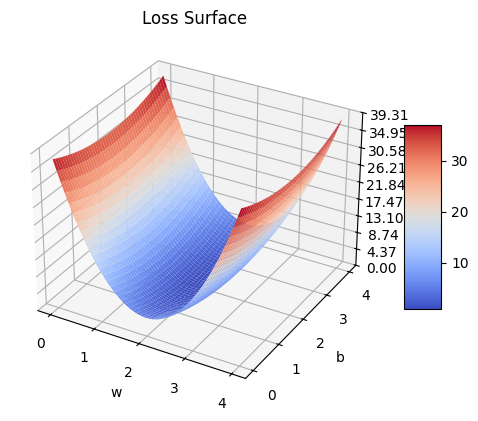

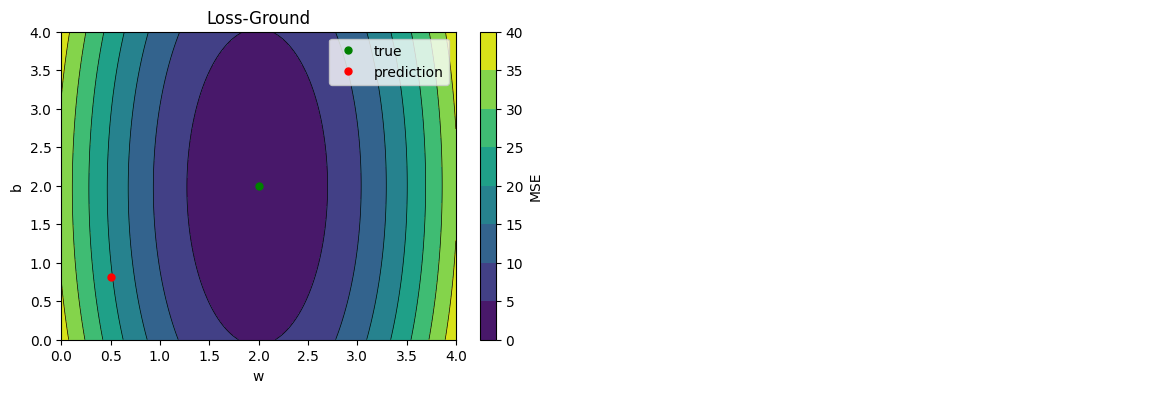

In [ ]:
term = Calculator(x_train, y_train)
mse_value = term.mse(term.w_mesh,term.b_mesh)

def surface_3d(w_mesh, b_mesh, mse, title, dpi=200, z_lim=None):
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  surf = ax.plot_surface(w_mesh, b_mesh, mse, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True,
                       zsort='average')
  if z_lim is not None:
    ax.set_zlim(z_lim)
  ax.zaxis.set_major_formatter('{x:.02f}')
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.set_title(title)
  ax.set_xlabel("w")
  ax.set_ylabel("b")
  return fig, ax

def mse_contour(
    w_axis, b_axis, mse, w_pred, b_pred,true_m=true_m, true_b=true_b,
):
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))
  cf = ax1.contourf(w_axis,b_axis, mse, levels=8)
  c = ax1.contour(w_axis,b_axis,mse, levels=cf.levels,colors="black" ,linewidths=0.5)
  fig.colorbar(cf, ax=ax1, label="MSE")
  ax2.set_axis_off()
  ax1.set_xlabel("w")
  ax1.set_ylabel("b")
  ax1.set_title("Loss-Ground")
  ax1.plot(true_m, true_b, "go", ms=5, label=r"true")
  ax1.plot(w_pred, b_pred, "ro", ms=5, label="prediction")
  ax1.legend()
  return fig, ax1, ax2



figx, axx = surface_3d(term.w_mesh, term.b_mesh, mse_value,"Loss Surface", z_lim=0)
fi4, ax1, ax2 = mse_contour(term.w_axis, term.b_axis, mse_value, w, b)


Steigung der Funktion bei fixiertem b bzw. w. Wir können demensprechend eine horizontale bzw. vertikale in die Lossschüssel einzeichnen und merken schnell dass die Parameter unterschiedlichen Einfluss auf den MSE haben. Die Funktion auf der rechten Seite ist nichts anderes als die Visualiserung dieser Linien.

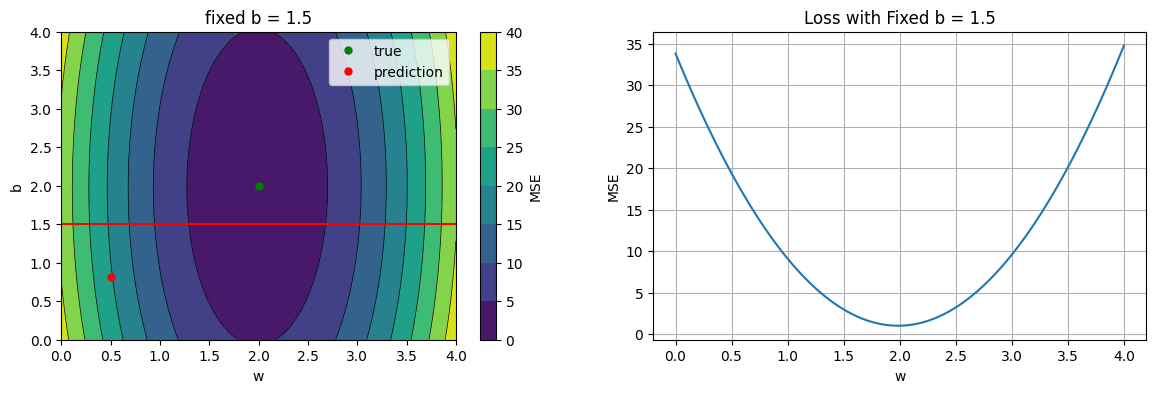

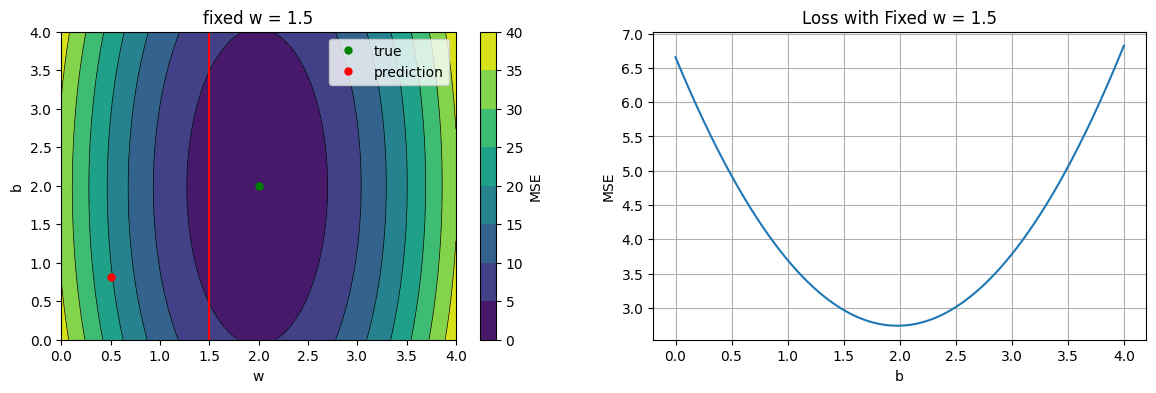

In [ ]:
fig5, ax1, ax2 = mse_contour(term.w_axis, term.b_axis, mse_value, w, b)
FIXED_B = 1.5
ax1.axhline(FIXED_B, color="red")
ax1.set_title(f"fixed b = {FIXED_B}")

def input_check(label: str):
  lab = label.lower()
  if lab not in {"w", "b"}:
    raise ValueError("Input has to be w or b")
  return lab

def viz_mse_fixed_param(term: Calculator, ax_object,coord_x_axis, x_axis_label, param, title):
  lab = input_check(x_axis_label)
  if lab == "w":
    mse_fix = term.mse(coord_x_axis, param * np.ones_like(coord_x_axis))
  else:
    mse_fix = term.mse(param * np.ones_like(coord_x_axis),coord_x_axis)
  ax2.set_axis_on()
  ax2.grid()
  ax2.set_ylabel("MSE")
  ax2.set_xlabel(lab)
  ax2.set_title(title)
  ax2.plot(coord_x_axis, mse_fix)

viz_mse_fixed_param(term, ax2, term.w_axis, "w", FIXED_B, f"Loss with Fixed b = {FIXED_B}")

fig6, ax1, ax2 = mse_contour(term.w_axis, term.b_axis, mse_value, w, b)
FIXED_W = float(1.5)
ax1.axvline(FIXED_W, color="red")
ax1.set_title(f"fixed w = {FIXED_W}")
viz_mse_fixed_param(term, ax2, term.b_axis, "b", FIXED_W, f"Loss with Fixed w = {FIXED_W}")


## 6. Partielle Ableitungen und Gradient Descent in 1D

Um zu verstehen, wie sich die Parameter $w$ und $b$ **unabhängig voneinander** auf den Fehler auswirken, betrachten wir sie einzeln:

**Linker Plot:** Zeigt den MSE-Verlauf in Abhängigkeit von einem Parameter ($w$ oder $b$), während der andere fixiert bleibt.

**Rechter Plot:** Zeigt die zugehörige partielle Ableitung $\frac{\partial \text{MSE}}{\partial w}$ bzw. $\frac{\partial \text{MSE}}{\partial b}$.

Wir führen Gradient Descent Updates **nur für einen Parameter** durch, nach der Update-Regel:

$\text{Parameter}_{\text{neu}} = \text{Parameter}_{\text{alt}} - \alpha \cdot \frac{\partial \text{MSE}}{\partial \text{Parameter}}$

wobei $\alpha$ die Lernrate ist.

Der Gradient zeigt in die Richtung des steilsten Anstiegs, deshalb das **-** Vorzeichen, weil wir in Richtung des steilsten Abstiegs updaten.


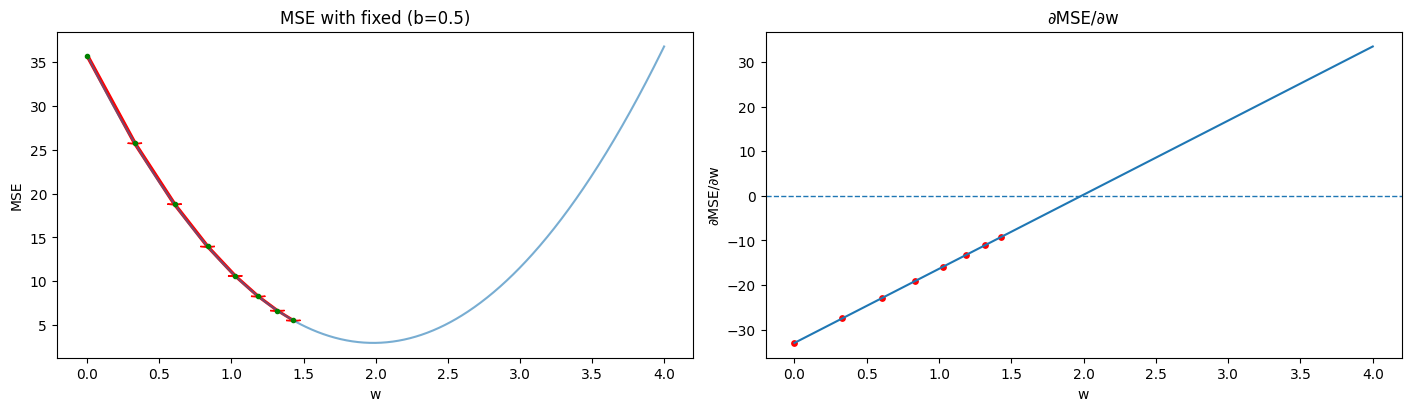

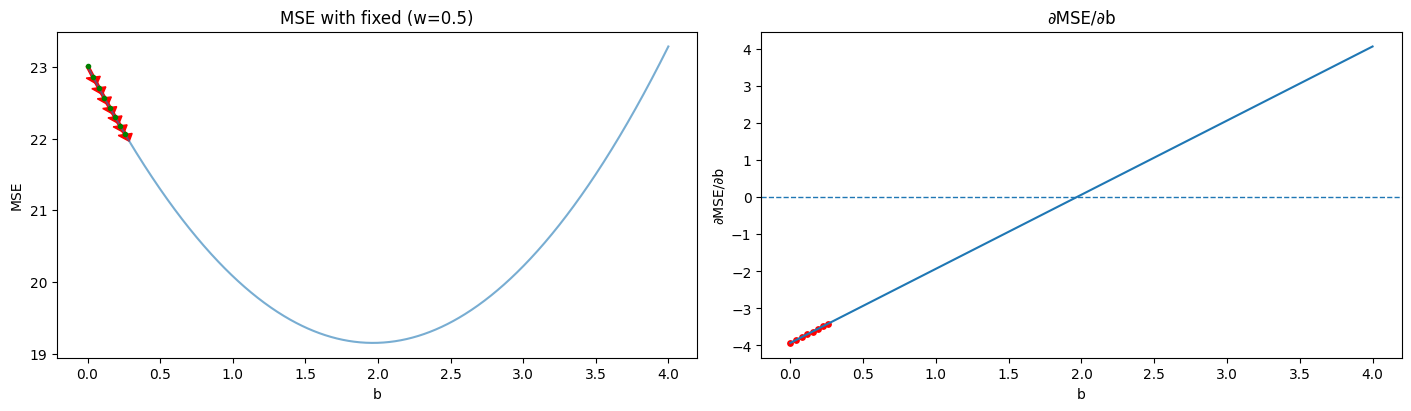

In [ ]:
# ∂MSE/∂w bei fixem b
# entkopplung von w und b sichtbar durch zentrieren

def viz_pderivate(term: Calculator, axis, fixed_param_value, label_x_axis):
  lab = input_check(label_x_axis)
  if lab == "w":
    mse = term.mse(axis, fixed_param_value * np.ones_like(axis))
    grad_component = term.grad_w(axis,fixed_param_value)
    title_ = "b"
  else:
    mse = term.mse(fixed_param_value * np.ones_like(axis), axis)
    grad_component = term.grad_b(fixed_param_value,axis)
    title_ = "w"

  fig, (axL, axR) = plt.subplots(1, 2, figsize=(14,4), constrained_layout=True)
  axL.plot(axis, mse, alpha=0.6)
  axL.set_xlabel(lab)
  axL.set_title(f"MSE with fixed ({title_}={fixed_param_value})")
  axL.set_ylabel("MSE")
  axR.plot(axis, grad_component)
  axR.axhline(0, ls="--", lw=1)
  axR.set_xlabel(lab)
  axR.set_ylabel(f"∂MSE/∂{lab}")
  axR.set_title(f"∂MSE/∂{lab}")
  return fig, (axL,axR), fixed_param_value

def viz_update(term: Calculator,
               ax,
               ax2,
               update_trgt,
               fixed_param_value,
               label_x_axis,
               learning_rate = 0.01,
               n_loop=1
               ):

  lab = input_check(label_x_axis)
  x , y, grad_list, step = [], [], [], []
  counter = 0

  for i in range(n_loop):

    if lab == "w":
      mse = term.mse(update_trgt, fixed_param_value)
      grad_component = term.grad_w(update_trgt,fixed_param_value)
    else:
      mse = term.mse(fixed_param_value, update_trgt)
      grad_component = term.grad_b(fixed_param_value,update_trgt)

    x.append(update_trgt)
    y.append(mse)
    grad_list.append(grad_component)

    #plot the start point
    ax.plot(update_trgt, mse, "go", ms=3)

    updadte_step = - (learning_rate * grad_component)
    step.append(updadte_step)

    update_trgt += updadte_step

    #print(f"mse = {y[i]} , grad = {grad_list[i]} , w = {x[i]}")
    if counter >= 1:
      ax.arrow(x[i-1], y[i-1], step[i-1], y[i] - y[i-1], color="red", width=0.02, head_width=0.1,head_length=0.10,)


    counter += 1
  ax2.scatter(x,grad_list, c="red", s=15)




fig7,(ax1,ax2), param1 = viz_pderivate(term, term.w_axis, 0.5, "w" )
fig8,(ax3,ax4), param2 = viz_pderivate(term, term.b_axis, 0.5, "b" )
#0.13 max
viz_update(term, ax1, ax2, 0, param1, "w", n_loop=8, learning_rate = 0.01)
viz_update(term, ax3, ax4, 0, param2, "b", n_loop=8, learning_rate = 0.01)


## 7. Limitationen der globalen Lernrate und der vereinfachten update Regel

Aus den obigen Plots wird deutlich: Eine **einzige, globale Lernrate** $\alpha$ für alle Parameter ist selbst in diesem stark **vereinfachten Szenario** problematisch.

#### Was wir hier stark vereinfacht haben ( **die wichtigsten Punkte**):

**1. Dimensionalität:** Nur 2 Modell Parameter statt Tausende bis Millionen

**2. Stochastizität:** Vollständiger Gradient auf allen Daten, kein Mini-Batch Rauschen

**3. Nicht-Konvexität:** Einfache konvexe Loss-Funktion mit einem globalen Minimum
- Reale tiefe neuronale Netze sind [**Hochgradig nicht-konvex**](https://www.welchlabs.com/resources/loss-landscape-poster-digital-download?srsltid=AfmBOorX8Ps-T3bo2RDuw4VQNZm-x4YagRo_6y0CnrVUxzCqi2iAXg0m)
  - Unzählige lokale Minima
  - Sattelpunkte (Gradient = 0, aber kein Minimum)
  - Flache Plateaus (winzige Gradienten, kaum Fortschritt)
  - Schmale "Täler" und steile "Klippen"
  - **Ill-conditioned** Loss-Landschaften
- Eine feste LR kann in flachen Regionen stecken bleiben oder in steilen Regionen "überschießen"

**4. Keine Vanishing/Exploding Gradients**

**5. Keine Parameter-Abhängigkeiten:** $w$ und $b$ unabhängig betrachtet


**Trotz dieser Vereinfachungen** sehen wir bereits in unserem simplen 2D-Fall:
- Unterschiedliche Parameter haben unterschiedliche Gradienten-Skalen
- Eine Lernrate, die für $w$ gut funktioniert, kann für $b$ suboptimal sein
- Die optimale Lernrate ändert sich während des Trainings (groß am Anfang, kleiner am Ende)

**Ausblick:**

Aber nicht verzweifeln, wenn dir die Begriffe erstmal nichts sagen. Im Laufe meines Kurses werden wir uns damit genauer befassen. Hier geht es erstmal nur darum dir eine Intuition aufzubauen, im hierauf aufbauenden Notebook werden wir uns den Weg vom **GD** zum **Stochastic Gradient Descent** und anderen Optimizern ansschauen, sowie Strategien wie man die lr anpasst.



### Unterschiedliche Lernraten

Nun schauen wir uns mal an was passiert wenn wir unsere **lr** erhöhen.

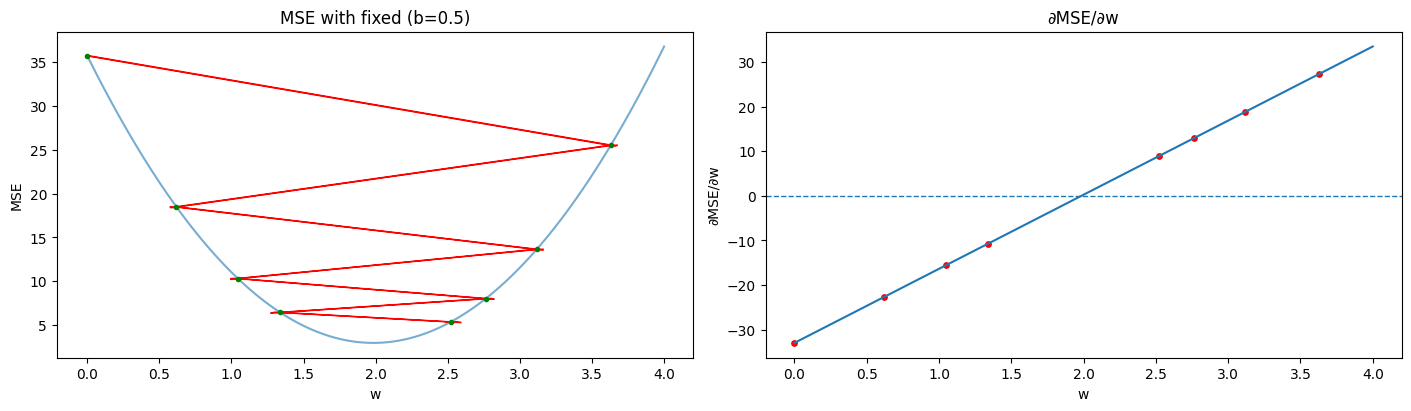

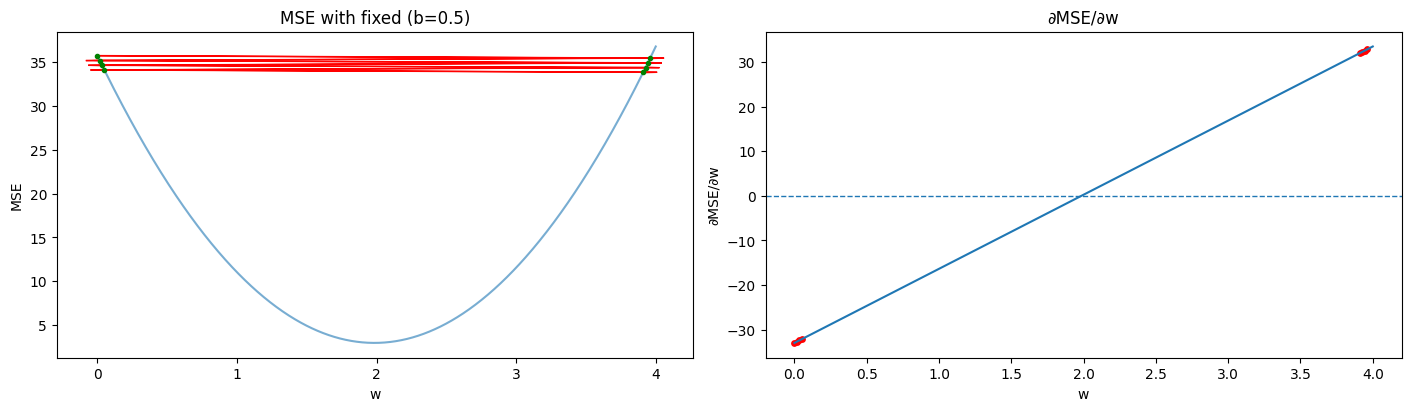

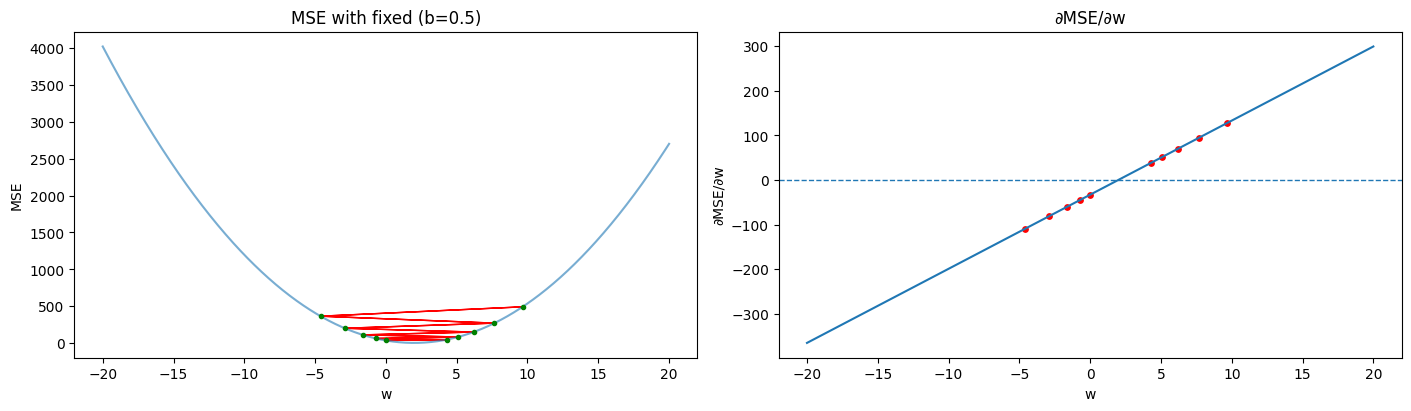

In [ ]:
term2 = Calculator(x_train,y_train,start_axis=-20,stop_axis=20)
fig5,(ax9,ax10), param3 = viz_pderivate(term, term.w_axis, 0.5, "w" )
fig6,(ax11,ax12), param4 = viz_pderivate(term, term.w_axis, 0.5, "w" )
fig7,(ax13,ax14), param5 = viz_pderivate(term2, term2.w_axis, 0.5, "w" )
#0.13 max
viz_update(term, ax9, ax10, 0, param3, "w", n_loop=8, learning_rate = 0.11)
viz_update(term, ax11, ax12, 0, param4, "w", n_loop=8, learning_rate = 0.12)
viz_update(term2, ax13, ax14, 0, param5, "w", n_loop=10, learning_rate = 0.13)


### Erkenntnis:
1. Im ersten Plot erkennen wir dass das minimum übersprungen wird, jedoch die Parametupdates trotzdem zum MSE minimum konvergieren

2. Im zweiten Plot mit etwas höherer lr konvergiert das Modell trotzdem nur ist unser updatestep so stark, dass wir das Minimum viel weiter überschiessen als im Plot zuvor und sich dadurch der gradient nicht schnell genung sinkt. Das training kommt sehr langsam voran. Auch wenn wenn wir hier nur eine simple Loss Oberfläche haben, wird beim gedanklichen Übertrag, deutlich dass es bei hochgradig nicht konvexen und hochdimensionalen Oberflächen es keine gute Idee ist unsere Parameter unkontrolliert zu updaten

3. Im dritten Plot ist sorgt die lr dafür dass unser gradient explodiert
und wir vom Minimum divergieren.



## 8. Chainrule
Mithilfe der Kettenregel können wir den Gradienten berechnen. Wir werden das ausfühlich im Notebook **Backpropagation** behandeln, sobald wir bei **tiefen neuronalen Netzten** angekommen sind.
$$
\Large
\begin{aligned}
\nabla_{w,b}\,\text{MSE} &=
\begin{bmatrix}
\dfrac{\partial\,\text{MSE}}{\partial w} \\
\dfrac{\partial\,\text{MSE}}{\partial b}
\end{bmatrix}
=
\frac{2}{n}
\sum_{i=1}^{n}
\begin{bmatrix}
x_i(\hat{y_i} - y_i) \\
(\hat{y_i} - y_i)
\end{bmatrix}
\\[1em]
\frac{\partial{\text{MSE}}}{\partial{w}}
&= \frac{\partial{\text{MSE}}}{\partial{\hat{y_i}}}
   \frac{\partial{\hat{y_i}}}{\partial{w}}
= \frac{2}{n} \sum_{i=1}^n{x_i (\hat{y_i} - y_i)}
\\[0.8em]
\frac{\partial{\text{MSE}}}{\partial{b}}
&= \frac{\partial{\text{MSE}}}{\partial{\hat{y_i}}}
   \frac{\partial{\hat{y_i}}}{\partial{b}}
= \frac{2}{n} \sum_{i=1}^n{(\hat{y_i} - y_i)}
\end{aligned}
$$



In [ ]:
# With Chain rule C/z * z/w (or b)
def m_grad(x,y,y_hat):
  return (2/len(y)) * ((y_hat-y) * x).sum()

def b_grad(y,y_hat):
  return 2 * (y_hat-y).mean()

lr = 0.01 # oder lr * 2 und die Ableitung vereinfachen von MSE 1/2n(...)

def update_target(target, gradient, lr=lr):
  new_target = target - lr * gradient
  return new_target



## 9. Training:
Wir trainieren das Modell über 400 Epochen, die Kernidee:
1. Erstelle eine Prediction
2. Berechne den Loss der Prediction zu den True Werten aus dem Train Set
3. Berechne die 2 Komponenten des Gradienten
4. Update w und b mit einer **lr** von 0.01
5. Validiere nun anhand des Val Sets, verwende dabei die updated parameters

In [ ]:
epoch = 400
train_loss, val_loss , pred_history = [], [], []
w_path, b_path = [], []

def train(x_train,y_train,w,b):
  y_hat = predict(x_train,w,b)
  pred_history.append(y_hat)
  loss = mse(y_train,y_hat)
  mg = m_grad(x_train,y_train,y_hat)
  bg = b_grad(y_train,y_hat)
  w = update_target(w,mg)
  b = update_target(b,bg)
  w_path.append(w)
  b_path.append(b)
  return w,b,loss

def validate(x_val,y_val,w,b):
  y_hat_val = predict(x_val, w, b)
  v_loss = mse(y_val, y_hat_val)
  return v_loss


for e in range(1,epoch+1):
  w,b,t_loss = train(x_train,y_train,w,b)
  v_loss = validate(x_val,y_val,w,b)
  train_loss.append(t_loss)
  val_loss.append(v_loss)
print(f"trained w={w:4f}, trained b={b:4f}")



trained w=1.986688, trained b=1.985263


## 10. Visualisierung des Loss
Im nächsten Schritt visualisieren wir den train und val loss. Selbst bei einem so simplen Problem gibt es uns ausschlussreiche Informationen welche wir daraus ableiten können. Wir sehen, dass das Modell zunächst schnell Richtung Optimum konvergiert. Anschließend flacht die Kurve sichtbar ab, weil die Gradienten nahe des Minimums sehr klein werden und weitere Verbesserungen nur langsam erfolgen. Der nahezu identische Verlauf von Trainings- und Validierungs-Loss weist darauf hin, dass das Modell sehr gut generalisiert. Der verbleibende Fehler ist damit überwiegend auf den Bias bzw. auf strukturelle Modellgrenzen oder Datenrauschen zurückzuführen und lässt sich durch längeres Training praktisch nicht weiter reduzieren.

#### Anmerkung:
Beim Training tiefer neuronaler Netze steigt der Rechenaufwand schnell an, sodass lange Trainingsphasen sehr kostenintensiv werden können. Für ein synthetisch generiertes Dataset wie in unserem Beispiel spielt das zwar keine große Rolle, in realen Szenarien jedoch schon. Eine gängige Maßnahme zur Reduktion von Trainingszeit ist Early Stopping:
Bleibt der Validierungs-Loss über mehrere Epochen hinweg unterhalb eines festgelegten Verbesserungs-Schwellwerts, wird das Training automatisch beendet. Dadurch spart man Rechenzeit und verhindert unnötige Optimierungsschritte, die nicht mehr zur Generalisierung beitragen.

Der Effekt von Early Stopping auf bestimmte Trainingsdynamiken, wie z. B. das sogenannte , *[Grokking](https://en.wikipedia.org/wiki/Grokking_(machine_learning)* besprechen wir später separat.




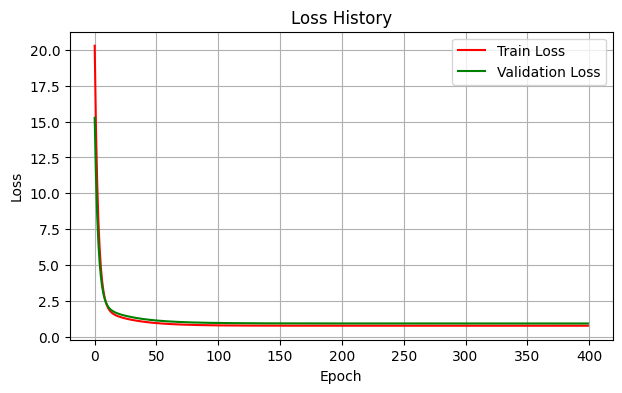

In [ ]:
def plot_loss(train_loss, val_loss):
  fig, ax = plt.subplots(figsize=(7,4))
  ax.plot(train_loss, c="red", label="Train Loss")
  ax.plot(val_loss, c= "green", label ="Validation Loss")
  ax.legend()
  ax.set_title("Loss History")
  ax.grid()
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epoch")

plot_loss(train_loss, val_loss)

In [ ]:
w_path = np.array(w_path)
b_path = np.array(b_path)

assert(
    np.min(w_path) >= np.min(term.w_axis)
    and np.max(w_path) <= np.max(term.w_axis)
) ,"Path can't be fully shown, rearrange the term w axis"


assert(
    np.min(b_path) >= np.min(term.b_axis)
    and np.max(b_path) <= np.max(term.b_axis)
), "Path can't be fully shown, rearrange the term b axis"

### Update Pfad
In unserer "Loss-Schüssel" können wir den update Pfad einzeichnen. Wie wir schon im **GD** in 1d beobachtet haben, konvergiert w schneller richtung minimum als b.

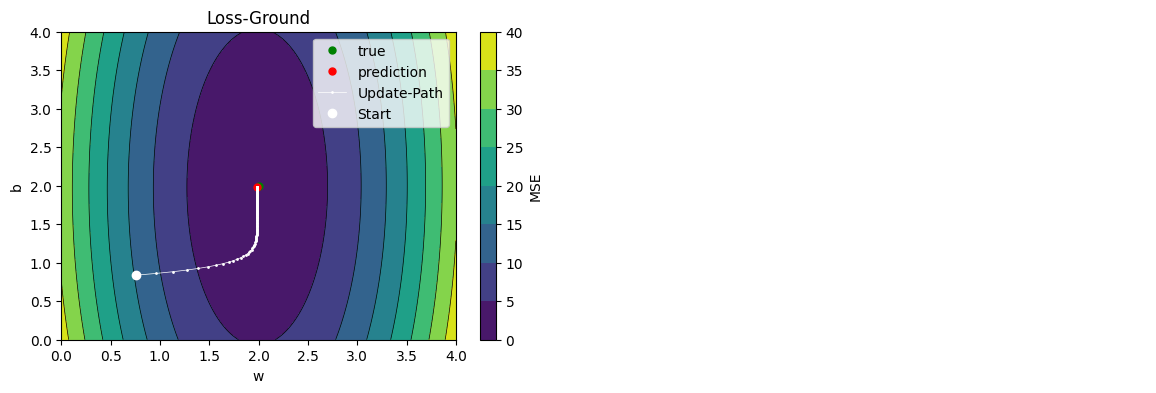

In [ ]:
fi4, ax1, ax2 = mse_contour(term.w_axis, term.b_axis, mse_value, w, b)

def viz_path(ax1,w_path,b_path):
  ax1.plot(w_path, b_path, ".-", lw=0.5, ms=2, color="w", label="Update-Path")
  ax1.plot(w_path[0], b_path[0], "wo", ms=6, label="Start")
  ax1.legend()

viz_path(ax1,w_path,b_path)

Hier sehen wir, wie das Modell predicted. Wir können da sehr schön das lernverhalten mit unterschiedlicher **lr** beobachten. Einfach dafür die lr im Notebook erhöhen und die ensprechenden Zellen ausführen.

In [ ]:
def timelapse(x,y,predictions,showtime=0.2):
  fig, ax = plt.subplots(figsize=(7,4))
  ax.scatter(x, y, s=3, c="red", label="noise")
  ax.grid()
  ax.set_xlabel("x")
  ax.set_ylabel("prediction")
  pred_plot = ax.scatter(x, predictions[0], s=1, c="blue", label="pred")
  #ax.set_ylim(-100,100)
  handle = display(fig, display_id=True)
  for pred in predictions:
    offset = np.column_stack((x,pred))
    pred_plot.set_offsets(offset)
    fig.canvas.draw_idle()
    handle.update(fig)
    plt.pause(showtime)


#timelapse(x_train,y_train,pred_history)

## 11. Viszualize Gradient Norm

Der Gradient ist ein **Vektor**, der an jedem Punkt $(w, b)$ in die Richtung des steilsten Anstiegs zeigt. In unserem Fall hat er zwei Komponenten: die partielle Ableitung nach $w$ und nach $b$. Diese Struktur macht eine direkte Visualisierung in 3D schwierig, wir müssten an jedem Punkt zwei separate Pfeile oder einen Vektorpfeil zeigen, was schnell unübersichtlich wird. Natürlich gibt es auch Möglichkeiten Losslandscapes in n-dimensionalen Parameterräumen vereinfacht darzustellen, aber das würde den Rahmen unseres Themas hier sprengen.

Stattdessen visualisieren wir die **Gradient Norm**, also die **Länge des Gradienten-Vektors**:

$$\|\nabla \text{MSE}\| = \sqrt{\left(\frac{\partial \text{MSE}}{\partial w}\right)^2 + \left(\frac{\partial \text{MSE}}{\partial b}\right)^2}$$

Die Norm ist ein einzelner Skalar-Wert, der uns wichtige Informationen liefert: Sie misst, **wie stark sich die Loss-Funktion an dieser Stelle verändert**, unabhängig von der konkreten Richtung. Eine große Norm bedeutet, dass wir uns in einer steilen Region befinden, egal ob die Steigung von $w$, von $b$, oder von beiden kommt. Eine kleine Norm hingegen signalisiert eine flache Region, und im Minimum, Maximum sowie an Sattelpunkten wird die Norm zu Null.

Die Gradient Norm bestimmt direkt die **Schrittgröße** beim Gradient Descent Update: In Regionen mit großer Norm (steile Hänge) macht dieser vereinfachte Algorithmus große Schritte, während er in flachen Regionen nur kleine Schritte macht. Das sehen wir aus der Visualisierung.

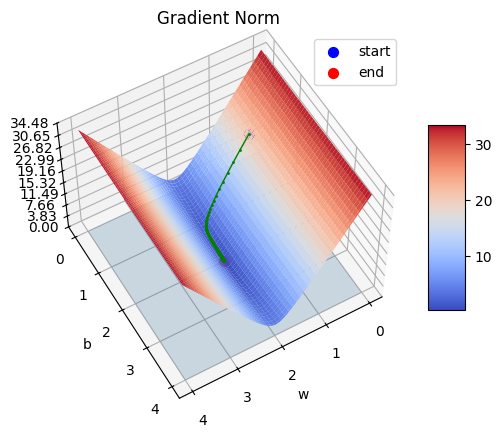

In [ ]:
term.set_mesh(0,4,n=100)
db = term.grad_b(term.w_mesh,term.b_mesh)
dw = term.grad_w(term.w_mesh,term.b_mesh)
norm = np.sqrt(dw**2 + db**2)

#gradienpath
w_path = np.array(w_path)
b_path = np.array(b_path)
dw_path = term.grad_w(w_path, b_path)
db_path = term.grad_b(w_path, b_path)
norm_path = np.sqrt(dw_path**2 + db_path**2)

def show_path(ax, w_path, b_path, path):
  ax.plot(w_path,b_path,path,marker="o",ms=1,linestyle="-",linewidth=1,c="green", zorder=10)
  ax.scatter(w_path[0],  b_path[0],  path[0] + 0.001,  s=50, c="b", label="start", zorder=11)
  ax.scatter(w_path[-1], b_path[-1], path[-1] + 0.001, s=50, c="r",label="end", zorder=11)
  ax.legend()


fig9,ax9 = surface_3d(term.w_mesh,term.b_mesh,norm,"Gradient Norm",z_lim=0)
ax9.view_init(elev=55, azim=60)
show_path(ax9,w_path,b_path,norm_path)

z0 = np.zeros_like(term.w_mesh)
ax9.plot_surface(
    term.w_mesh,
    term.b_mesh,
    z0,
    alpha=0.2,
    linewidth=0,
    antialiased=True,
)

## 12. Visualisierung der Gradientenkomponenten

In diesen Visualisierungen wird die jeweilige Gradientenkomponente $\frac{\partial L}{\partial w}$ bzw. $\frac{\partial L}{\partial b}$ dargestellt. Die Höhe der Oberfläche zeigt also nicht den Loss an, sondern ausschließlich den Wert der entsprechenden Ableitung an jedem Punkt des Parameterraums.

Die dargestellte Fläche gibt damit Auskunft darüber, wie stark und in welche Richtung sich die Loss-Funktion lokal verändert.

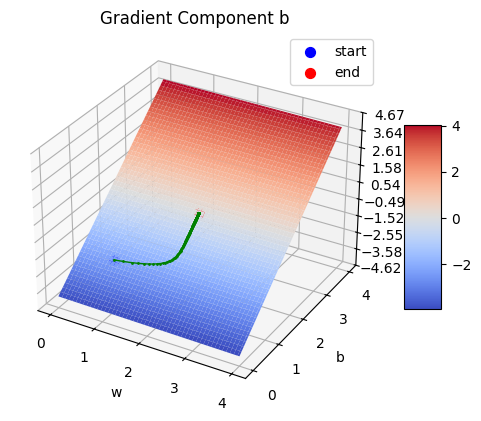

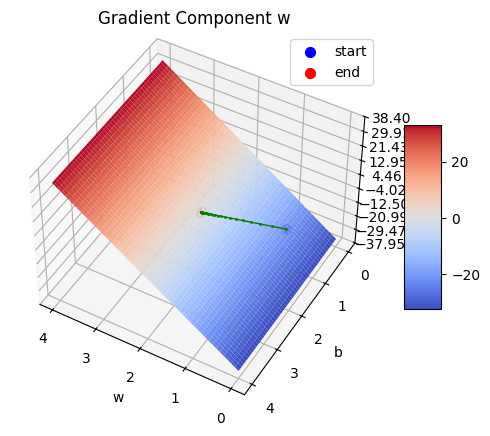

In [ ]:
fig10,ax10 = surface_3d(term.w_mesh,term.b_mesh,db,"Gradient Component b")
show_path(ax10,w_path,b_path,db_path)

fig11,ax11 = surface_3d(term.w_mesh,term.b_mesh,dw,"Gradient Component w")
show_path(ax11,w_path,w_path,dw_path)
ax11.view_init(elev=45, azim=120)

Hiermit haben wir das Thema Gradientenabstieg behandelt und können nun verstehen wie wir dadurch später neuronale Netze nur diesmal mit Aktivierung trainieren. Da wir hier ein lineares Modell beschreiben können wir das einfach auch analytisch lösen mit der Methode der kleinsten Quadrate.

## 13. Lineares Modell und Designmatrix

Wir betrachten ein lineares Regressionsmodell. Linear in diesem Kontext bedeutet für uns nicht eine Gerade, sondern bezieht sich auf den Parameterraum $w$. Der Featureraum $X$ kann nichtlinear sein, beispielsweise $[1,\; x,\; x^2]$.

Da wir in unserem Fall eine lineare Gleichung approximieren wollen, mit

$$f(x) = m \cdot x + b,$$

bewegen wir uns in einem zweidimensionalen Parameterraum → $w_1 \cdot x + w_0 \cdot 1$.

Natürlich könnte man diesen erweitern, jedoch muss eine Semantik dahinterstecken. Beispielsweise wäre

$$w_2 \cdot x_1 + w_1 \cdot x_1 + w_0 \cdot 1$$

nichts anderes als

$$(w_2 + w_1) \cdot x_1 + w_0 \cdot 1.$$

Das ist problematisch, da wir nun in der Designmatrix eine lineare Abhängigkeit geschaffen haben. Dadurch ist $\Phi^\top \Phi$ nicht mehr garantiert invertierbar, weil

$$\operatorname{rank}(\Phi) < D+1.$$

Das Gleichungssystem hätte dann unendlich viele Lösungen, und die folgende Gleichung könnte nicht mehr verwendet werden und wir müssten einen anderen Ansatz wählen.

Es gibt Wege, wie man den Feature-Raum über Feature-Engineering sinnvoll erweitern kann. Das werden wir uns jedoch in einem späteren Kapitel anschauen.

$$
\hat{y} = f(x; w) = w_0 + w_1 x_1 + \dots + w_D x_D = w^T \phi(x)
$$

mit

$$
\phi(x) =
\begin{pmatrix}
1 \\
x_1 \\
\vdots \\
x_D
\end{pmatrix},
\quad
w =
\begin{pmatrix}
w_0 \\
w_1 \\
\vdots \\
w_D
\end{pmatrix}
$$

Für $n$ Datenpunkte fassen wir alle Feature-Vektoren zu einer **Designmatrix** $\Phi$ zusammen:

$$
\Phi =
\begin{pmatrix}
\phi(x_1)^T \\
\phi(x_2)^T \\
\vdots \\
\phi(x_n)^T
\end{pmatrix}
\in \mathbb{R}^{n \times (D+1)}
$$

Dann gilt kompakt

$$
\hat{y} = \Phi w
$$

In [ ]:
def design_matrix(x):
  x = np.column_stack((np.ones_like(x),x))
  return x

phi_train = design_matrix(x_train)
phi_val = design_matrix(x_val)

## 14. Fehlerfunktion (SSE/MSE) und Normalengleichungen

Wir definieren die Summe der Fehlerquadrate (SSE) als

$$
O(w) = \sum_{i=1}^n (y_i - w^T \phi(x_i))^2
     = \| y - \Phi w \|^2
     = (y - \Phi w)^T (y - \Phi w)
$$

Wie wir unschwer ekennen ist der MSE, nicht anderes als eine skalierung des SSE um 1/n. Da sich dadurch das Minimum nicht verändert, können wir uns die Lossoberfläche im oberen Abschnitt anschauen. Dort wird deutlich, dass mit der Konvexität, die wichtigste Eigenschaft der Loss Funktion für den Ansatz erfüllt ist.

$$
\tilde{O}(w) = \frac{1}{2} \| y - \Phi w \|^2
$$

Die Ableitung nach $w$ ergibt:

$$
\nabla_w \tilde{O}(w)
= \Phi^T \Phi w - \Phi^T y
$$

Minimum: setze $\nabla_w \tilde{O}(w) = 0$:

$$
\Phi^T \Phi w = \Phi^T y
$$

Das sind die **Normalengleichungen**. Falls $\Phi^T \Phi$ invertierbar ist:

$$
\hat{w} = (\Phi^T \Phi)^{-1} \Phi^T y
$$



In [ ]:
w_hat = np.linalg.inv(phi_train.T @ phi_train) @ phi_train.T @ y_train
print(f"w_hat = {w_hat}")
print(f"The parameters we calculated with gradient descent: bias Term: {b}, w0: {w}")

w_hat = [1.98562596 1.98668856]
The parameters we calculated with gradient descent: bias Term: 1.9852628900702307, w0: 1.9866878917864874


Es ist unschwer zu erkennen, dass wir mit beiden Methoden sehr identische Parameter bekommen haben. Das liegt daran dass wir beim Gradientenabstieg einen iterrativen Optimierungsverfahren benutzen der unsere zufäliig initilaliserten Parameter zu einem niedrigeren Loss konvergieren lässt. Hier wird es analytisch berechnet. Aussage 2 haben wir damit untermauert.

> 2. Durch das hinzufügen von normalverteilten Rauschen ist der Fehler selbst bei wahren Parametern nicht mehr 0 *(true_m, true_b)* . Das heißt unsere optimalen Modell Parameter unterscheiden sich von den "wahren" Werten.


